In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

df = pd.read_excel("amazon.xlsx")
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


1. Text Preprocessing

In [3]:
###############################
# Normalizing Case Folding
###############################

df['Review'] = df['Review'].str.lower()

In [4]:
###############################
# Punctuations
###############################

df['Review'] = df['Review'].str.replace('[^\w\s]', '')

In [5]:
###############################
# Numbers
###############################

df['Review'] = df['Review'].str.replace('\d', '')

In [6]:
###############################
# Stopwords
###############################

import nltk
from nltk.corpus import stopwords

sw = stopwords.words('english')
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

In [7]:
###############################
# Rarewords
###############################

sil = pd.Series(' '.join(df['Review']).split()).value_counts()[-1000:]
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in x.split() if x not in sil))

In [8]:
###############################
# Lemmatization
###############################

from textblob import Word, TextBlob
nltk.download('wordnet')

df['Review'] = df['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\is\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


2. Text Visualization

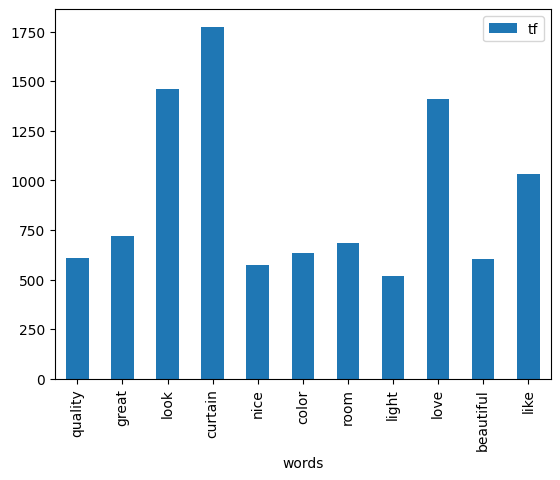

In [9]:
###############################
# Terim Frekanslarının Hesaplanması
###############################

import matplotlib.pyplot as plt

tf = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.columns = ["words", "tf"]
tf.sort_values("tf", ascending=False)

tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

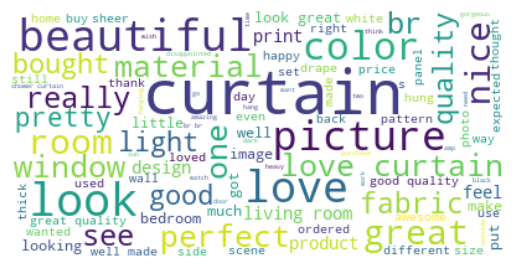

In [10]:
###############################
# Wordcloud
###############################

from wordcloud import WordCloud

text = " ".join(i for i in df.Review)

wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

3. Sentiment Analysis

In [11]:
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

df["Review"][0:10].apply(lambda x: sia.polarity_scores(x))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\is\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


0    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...
1    {'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compou...
2    {'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'comp...
3    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4    {'neg': 0.0, 'neu': 0.517, 'pos': 0.483, 'comp...
5    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6    {'neg': 0.0, 'neu': 0.631, 'pos': 0.369, 'comp...
7    {'neg': 0.0, 'neu': 0.541, 'pos': 0.459, 'comp...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 0.753, 'pos': 0.247, 'comp...
Name: Review, dtype: object

In [12]:
df["polarity_score"] = df["Review"].apply(lambda x: sia.polarity_scores(x)["compound"])

4. Feature Engineering

In [13]:
df["sentiment_label"] = df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

In [14]:
from sklearn.preprocessing import LabelEncoder

df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])


In [15]:
X = df["Review"]
y = df["sentiment_label"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = CountVectorizer()
X_train_count = vectorizer.fit_transform(X_train)
X_test_count = vectorizer.transform(X_test)


tf_idf_word_vectorizer = TfidfVectorizer()
X_train_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X_train)
X_test_tf_idf_word = tf_idf_word_vectorizer.transform(X_test)

tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2, 3))
X_train_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(X_train)
X_test_tf_idf_ngram = tf_idf_ngram_vectorizer.transform(X_test)

5. Sentiment Modeling

In [16]:
###############################
# Logistic Regression
###############################

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

# Count Vectors
print("Count Vectors")
log_model = LogisticRegression().fit(X_train_count, y_train)
y_pred_count = log_model.predict(X_test_count)
print(classification_report(y_pred_count, y_test))
print(cross_val_score(LogisticRegression(), CountVectorizer().fit_transform(X), y, scoring="accuracy", cv=3).mean())

# TF-IDF Word-Level
print("TF-IDF Word-Level")
log_model = LogisticRegression().fit(X_train_tf_idf_word, y_train)
y_pred_tf_idf_word = log_model.predict(X_test_tf_idf_word)
print(classification_report(y_pred_tf_idf_word, y_test))
print(cross_val_score(LogisticRegression(), TfidfVectorizer().fit_transform(X), y, scoring="accuracy", cv=3).mean())

# TF-IDF N-GRAM
print("TF-IDF N-GRAM")
log_model = LogisticRegression().fit(X_train_tf_idf_ngram, y_train)
y_pred_tf_idf_ngram = log_model.predict(X_test_tf_idf_ngram)
print(classification_report(y_pred_tf_idf_ngram, y_test))
print(cross_val_score(LogisticRegression(), TfidfVectorizer(ngram_range=(2, 3)).fit_transform(X), y, scoring="accuracy", cv=3).mean())

Count Vectors
              precision    recall  f1-score   support

           0       0.75      0.88      0.81       191
           1       0.98      0.95      0.97      1212

    accuracy                           0.94      1403
   macro avg       0.86      0.92      0.89      1403
weighted avg       0.95      0.94      0.94      1403

0.938157790690252
TF-IDF Word-Level
              precision    recall  f1-score   support

           0       0.31      0.97      0.47        71
           1       1.00      0.88      0.94      1332

    accuracy                           0.89      1403
   macro avg       0.65      0.93      0.70      1403
weighted avg       0.96      0.89      0.91      1403

0.885226141377303
TF-IDF N-GRAM
              precision    recall  f1-score   support

           0       0.02      1.00      0.03         4
           1       1.00      0.84      0.91      1399

    accuracy                           0.84      1403
   macro avg       0.51      0.92      0.47   

In [17]:
###############################
# Random Forests
###############################
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Count Vectors
print("Count Vectors")
rf_model = RandomForestClassifier().fit(X_train_count, y_train)
y_pred_count = rf_model.predict(X_test_count)
print(classification_report(y_pred_count, y_test))
print(cross_val_score(RandomForestClassifier(), CountVectorizer().fit_transform(X), y, scoring="accuracy", cv=3).mean())


# TF-IDF Word-Level
print("TF-IDF Word-Level")
rf_model = RandomForestClassifier().fit(X_train_tf_idf_word, y_train)
y_pred_tf_idf_word = rf_model.predict(X_test_count)
print(classification_report(y_pred_tf_idf_word, y_test))
print(cross_val_score(LogisticRegression(), TfidfVectorizer().fit_transform(X), y, scoring="accuracy", cv=3).mean())


# TF-IDF N-GRAM
print("TF-IDF N-GRAM")
rf_model = RandomForestClassifier().fit(X_train_tf_idf_ngram, y_train)
y_pred_tf_idf_ngram = rf_model.predict(X_test_tf_idf_ngram)
print(classification_report(y_pred_tf_idf_ngram, y_test))
print(cross_val_score(RandomForestClassifier(), TfidfVectorizer(ngram_range=(2, 3)).fit_transform(X), y, scoring="accuracy", cv=3).mean())


Count Vectors
              precision    recall  f1-score   support

           0       0.62      0.82      0.71       169
           1       0.97      0.93      0.95      1234

    accuracy                           0.92      1403
   macro avg       0.80      0.88      0.83      1403
weighted avg       0.93      0.92      0.92      1403

0.9233661162827699
TF-IDF Word-Level
              precision    recall  f1-score   support

           0       0.80      0.58      0.67       310
           1       0.89      0.96      0.92      1093

    accuracy                           0.88      1403
   macro avg       0.84      0.77      0.80      1403
weighted avg       0.87      0.88      0.87      1403

0.885226141377303
TF-IDF N-GRAM
              precision    recall  f1-score   support

           0       0.10      0.81      0.17        27
           1       1.00      0.85      0.92      1376

    accuracy                           0.85      1403
   macro avg       0.55      0.83      0.55  